<a href="https://colab.research.google.com/github/torifinch/Forecasting_app/blob/main/Grocery_Naive_SARIMA_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Grocery Time Series Model Foundations

Store 51 - Item 789224 Analysis

1. Check stationarity
2. Visualize ACF/PACF
3. Seasonal Decomposition
4. Fit a Naive forecast
6. Fit a SARIMA model

###Import & Load Data

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime

In [127]:
# Plotting style
sns.set(rc={'figure.figsize':(12, 6)})

In [128]:
# Load a specific store and item
df = pd.read_csv('/content/final_train1.csv', parse_dates=['date'])
df = df[(df['store_nbr'] == 51) & (df['item_nbr'] == 789224)]
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
monthly_df = df.groupby('month')['unit_sales'].sum().to_frame(name='value')
monthly_df.index = pd.to_datetime(monthly_df.index)
monthly_df = monthly_df.asfreq('MS')

In [129]:
# Add dropna here to remove any NaN values introduced by asfreq
monthly_df.dropna(inplace=True)

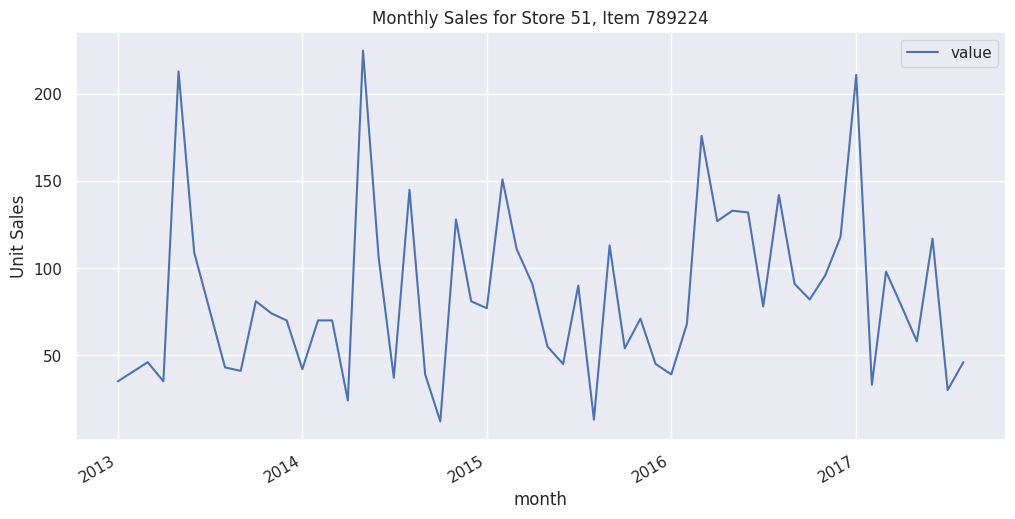

In [130]:
# Visualize raw data
monthly_df.plot(title='Monthly Sales for Store 51, Item 789224')
plt.ylabel("Unit Sales")
plt.show()

###Stationarity

In [131]:
# Check stationarity with ADF Test
result = adfuller(monthly_df['value'])
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
if result[1] < 0.05:
    print("✅ Series is stationary.")
else:
    print("⚠️ Series is likely non-stationary.")

ADF Statistic: -7.3040
p-value: 0.0000
✅ Series is stationary.


###ACF & PACF

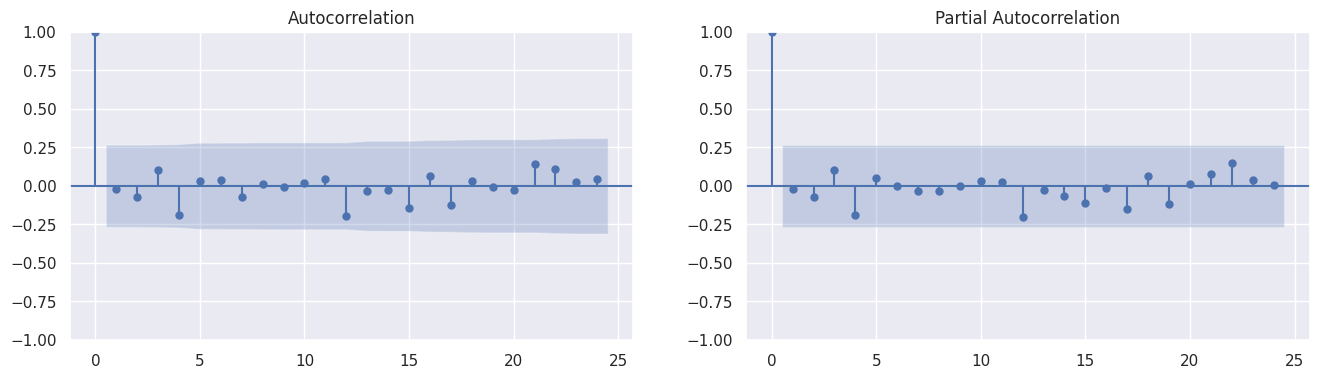

In [132]:
# ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(monthly_df['value'], ax=axes[0], lags=24)
plot_pacf(monthly_df['value'], ax=axes[1], lags=24)
plt.show()

### Seasonal Decomposition

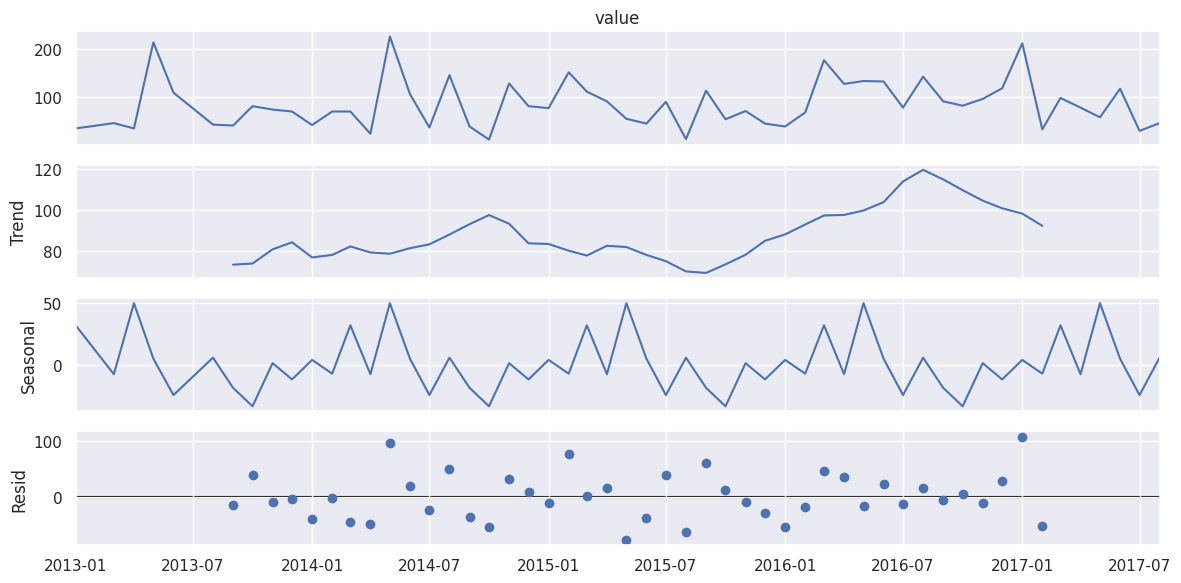

In [133]:
# Seasonal Decomposition
# Explicitly specify the period for monthly data (12 for a yearly cycle)
result = seasonal_decompose(monthly_df['value'], model='additive', period=12)  # or model='multiplicative'
result.plot()
plt.show()

###Naive Forecast - Previous Value

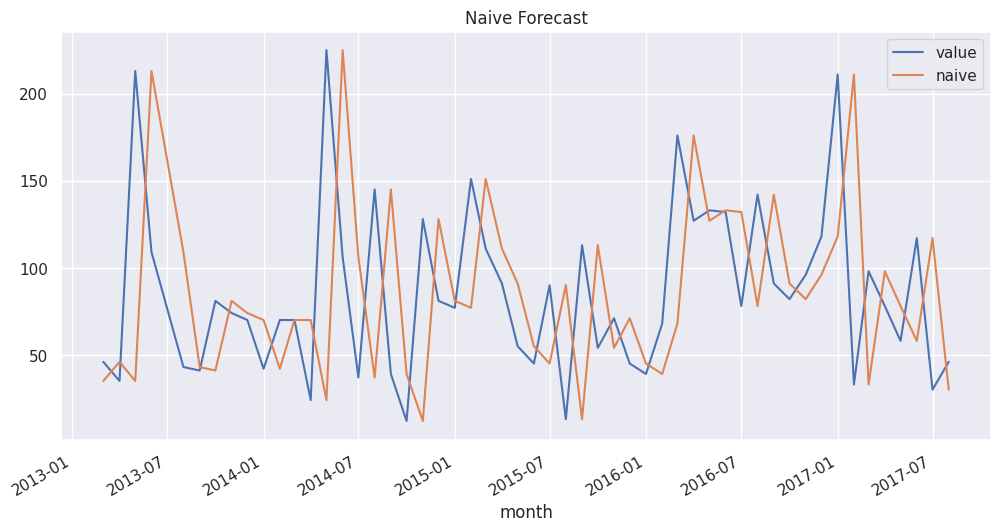

In [134]:
# Naive Forecast
monthly_df['naive'] = monthly_df['value'].shift(1)
# Add dropna here as well, as shift introduces NaN at the beginning
monthly_df.dropna(inplace=True)
monthly_df[['value', 'naive']].plot(title='Naive Forecast')
plt.show()

###SARIMA

In [135]:
# Fit SARIMA
model = sm.tsa.SARIMAX(monthly_df['value'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                   53
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -225.176
Date:                            Sun, 18 May 2025   AIC                            460.352
Time:                                    14:13:29   BIC                            468.796
Sample:                                         0   HQIC                           463.405
                                             - 53                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0633      0.195     -0.324      0.746      -0.446       0.320
ma.L1         -0.9992     15.412   

In [136]:
# Create summary table of model statistics
sarima_summary = {
    "Log Likelihood": model_fit.llf,
    "AIC": model_fit.aic,
    "BIC": model_fit.bic,
    "HQIC": model_fit.hqic
}
summary_table = pd.DataFrame(sarima_summary, index=["SARIMA(1,1,1)(1,1,1,12)"])
print("\nModel Summary Table:")
print(summary_table)



Model Summary Table:
                         Log Likelihood         AIC         BIC        HQIC
SARIMA(1,1,1)(1,1,1,12)     -225.175959  460.351918  468.796316  463.405146


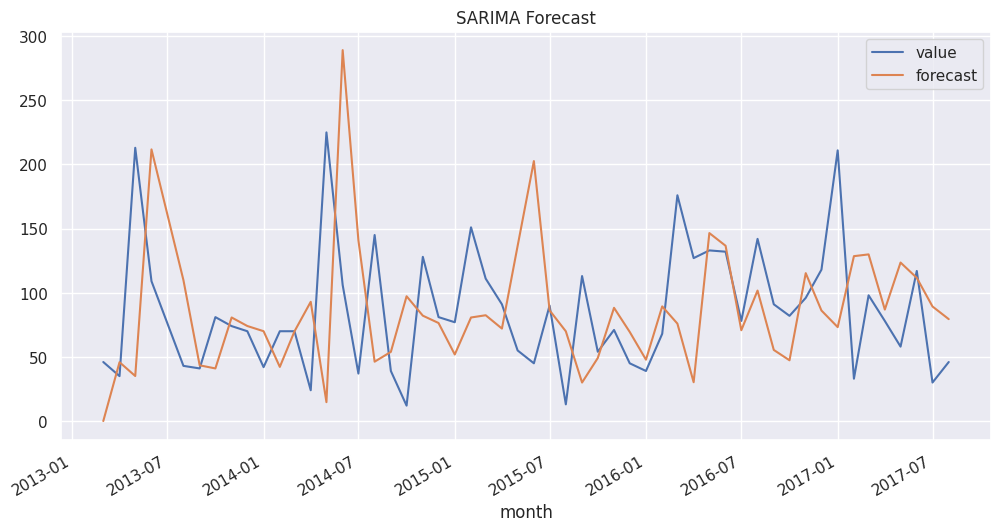

In [137]:
# Viz SARIMA
monthly_df['forecast'] = model_fit.predict(start=monthly_df.index[0], end=monthly_df.index[-1])
monthly_df[['value', 'forecast']].plot(title='SARIMA Forecast')
plt.show()

### Simple SARIMA Model

In [138]:
# Fit simpler SARIMA(0,1,1)(0,1,1,12) ---
simple_model = sm.tsa.SARIMAX(monthly_df['value'], order=(0,1,1), seasonal_order=(0,1,1,12))
simple_fit = simple_model.fit(disp=False)
print(simple_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                   53
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -226.214
Date:                            Sun, 18 May 2025   AIC                            458.427
Time:                                    14:13:30   BIC                            463.494
Sample:                                         0   HQIC                           460.259
                                             - 53                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9980      4.597     -0.217      0.828     -10.009       8.013
ma.S.L12      -0.9882     18.320   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [139]:
# Add to model comparison table
simple_summary = {
    "Log Likelihood": simple_fit.llf,
    "AIC": simple_fit.aic,
    "BIC": simple_fit.bic,
    "HQIC": simple_fit.hqic
}
simple_table = pd.DataFrame(simple_summary, index=["SARIMA(0,1,1)(0,1,1,12)"])
summary_table = pd.concat([summary_table, simple_table])
print("\n📊 Updated Model Comparison Table:")
print(summary_table)


📊 Updated Model Comparison Table:
                         Log Likelihood         AIC         BIC        HQIC
SARIMA(1,1,1)(1,1,1,12)     -225.175959  460.351918  468.796316  463.405146
SARIMA(0,1,1)(0,1,1,12)     -226.213612  458.427223  463.493861  460.259159


<function matplotlib.pyplot.show(close=None, block=None)>

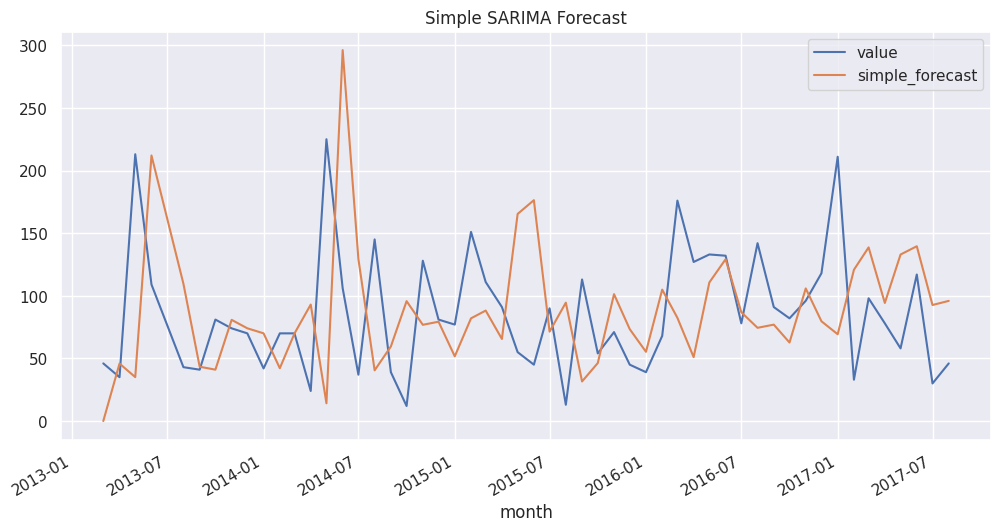

In [140]:
# Viz simple model
monthly_df['simple_forecast'] = simple_fit.predict(start=monthly_df.index[0], end=monthly_df.index[-1])
monthly_df[['value', 'simple_forecast']].plot(title='Simple SARIMA Forecast')
plt.show

## 🧾 Model Comparison Summary

We compared two forecasting models to predict monthly grocery sales:

- **SARIMA(1,1,1)(1,1,1,12)**: A more complex model
- **SARIMA(0,1,1)(0,1,1,12)**: A simpler alternative

Even though the complex model fits slightly better in some respects, the **simpler model actually performed just as well — and even slightly better when we look at the AIC score**, which balances accuracy and simplicity.

 **Bottom line**: Sometimes, simpler models are just as effective — and easier to interpret and maintain. The SARIMA(0,1,1)(0,1,1,12) model gives us solid predictions with less complexity.
